## Data and function loading 

In [1]:
from IPython.display import Image
import imageio
import matplotlib.patches as mpatches
import tensorflow as tf
import keras_unet_collection
from keras_unet_collection import models
from tensorflow.keras.models import Model
import cv2
import pywt
import numpy as np
import os
import pandas as pd
from PIL import Image
import scipy.io
import seaborn as sns
import tensorflow.keras.layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from statistics import mean
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import SamModel, SamProcessor
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
%matplotlib inline

2024-07-01 15:07:31.123697: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-01 15:07:31.674003: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def load_images_from_folder(folder, base_filename, num_images, keyname, file_extension='.mat', leading_zeros=False):
    images = []
    
    
    # loop through all images in folder
    for i in range(1, num_images + 1):
        
        
        # set file path for the next image
        filename = f"{base_filename}{i:04d}{file_extension}" if leading_zeros else f"{base_filename}{i}{file_extension}"
        file_path = os.path.join(folder, filename).replace('\\', '/')
        
        # load in the .mat file
        data = scipy.io.loadmat(file_path)
        
        # load image with keyname for the specific .mat file
        image = data.get(keyname, None) 
        images.append(image)

    return images

# load in X data
ultrasound_folder_train = "Training_us"
ultrasound_train = load_images_from_folder(ultrasound_folder_train, 'image', 1307,'image', '.mat', leading_zeros=True)
ultrasound_folder_test = "Test_us"
ultrasound_test = load_images_from_folder(ultrasound_folder_test, 'image', 417,'image', '.mat', leading_zeros=True)
ultrasound_folder_val = "Validation_us"
ultrasound_val = load_images_from_folder(ultrasound_folder_val, 'image', 523,'image', '.mat', leading_zeros=True)

# load in the Y data
segmentation_folder_train = "Training_seg"
segmentation_train = load_images_from_folder(segmentation_folder_train, 'segmentNew', 1307,'segment_new', '.mat', leading_zeros=True)
segmentation_folder_test = "Test_seg"
segmentation_test = load_images_from_folder(segmentation_folder_test, 'segmentNew', 417,'segment_new', '.mat', leading_zeros=True)
segmentation_folder_val = "Validation_seg"
segmentation_val = load_images_from_folder(segmentation_folder_val, 'segmentNew', 523,'segment_new', '.mat', leading_zeros=True)


Y_train = segmentation_train
Y_test = segmentation_test
Y_val = segmentation_val

X_train = ultrasound_train
X_test = ultrasound_test
X_val = ultrasound_val

## Preparing / Pre-processing the data

### Cropping and resizing the images

In [3]:
# set the indices needed for the different sets of patient ultrasounds
group_indices_train = {
    0: [0,191],
    1: [191,471],
    2: [471,707], 
    3: [707,912], 
    4: [912, 1176],
    5: [1176, 1307]
}

group_indices_test = {
    0: [0,194],
    1: [194,417]
}

group_indices_val = {
    0: [0,321],
    1: [321,522]
}


# set indices for cropping the different patients
cropping_params_train = {
    0: (0, 155, 30, 343),
    1: (0, 180, 0, 375),
    2: (0, 123, 48, 323),
    3: (0, 144, 44, 332),
    4: (0, 197, 15, 360),
    5: (0,110,62,309)
}

cropping_params_test = {
    0: (0,115, 48,323),
    1: (0,105, 75,298)
}

cropping_params_val = {
    0: (0,130, 54,317),
    1: (0,130,20,350)
}

def crop_image(images,croppers):
    cropped_images = []

    # crop each image according to the indices and resize to regain 192 by 384 pixels
    for img in images:
        cropped_image = img[croppers[0]:croppers[1], croppers[2]:croppers[3]]
        cropped_image = resize_image_with_crop(cropped_image)
        cropped_images.append(cropped_image)
        
    return np.array(cropped_images)

def crop_image_indices(images, group_indices, cropping_params):
    image_list = []
    
    # for each group of ultrasounds perform slicing operations
    for i in range(len(group_indices)):
        sliced_images = images[group_indices[i][0]:group_indices[i][1]]
        cropped_images = crop_image(sliced_images, cropping_params[i])
        image_list.extend(cropped_images)
    return np.array(image_list)

def resize_image_with_crop(img, target_size=(192, 384)):
    original_size = img.shape 

    # determine the target crop size which maintains the aspect ratio closest to the target size
    target_aspect = target_size[1] / target_size[0]
    original_aspect = original_size[1] / original_size[0]

    # crop to height when image is too tall
    new_height = int(original_size[1] * target_aspect)
    top = (original_size[0] - new_height) // 2
    cropped_img = img[top:top + new_height, :]

    # resize image using cv2.resize
    resized_img = cv2.resize(cropped_img, (target_size[1], target_size[0]))  # Note the order of dimensions
    return resized_img
        
X_train_resized = crop_image_indices(X_train,group_indices_train,cropping_params_train)
X_test_resized = crop_image_indices(X_test,group_indices_test,cropping_params_test)
X_val_resized = crop_image_indices(X_val, group_indices_val,cropping_params_val)

Y_train_resized = crop_image_indices(Y_train,group_indices_train,cropping_params_train)
Y_test_resized = crop_image_indices(Y_test,group_indices_test,cropping_params_test)
Y_val_resized = crop_image_indices(Y_val, group_indices_val,cropping_params_val)

Y_train_resized = Y_train_resized.astype(np.uint8)
Y_test_resized = Y_test_resized.astype(np.uint8)
Y_val_resized = Y_val_resized.astype(np.uint8)

X_train_resized = X_train_resized.astype(np.uint8)
X_test_resized = X_test_resized.astype(np.uint8)
X_val_resized = X_val_resized.astype(np.uint8)

### Applying median filtering

In [4]:
def apply_sobel_filtering(images, kernal_size=15):
    image_list = []
    for image in images:
        sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=15)
        sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=15)
        sobel_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
        sobel_magnitude = cv2.normalize(sobel_magnitude, None, 0, 255, cv2.NORM_MINMAX)
        sobel_magnitude = sobel_magnitude.astype(np.uint8)
        image_list.append(sobel_magnitude)
    return image_list


def wavelet_denoise(image, wavelet='sym3', level=3):
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    threshold = np.sqrt(2 * np.log2(image.size)) * np.median(np.abs(coeffs[-1][-1])) / 0.675
    new_coeffs = [(cH, pywt.threshold(cV, threshold, mode='soft'), pywt.threshold(cD, threshold, mode='soft'))
                  for cH, cV, cD in coeffs[1:]]  # detail coeffs only
    new_coeffs = [coeffs[0]] + new_coeffs
    denoised_image = pywt.waverec2(new_coeffs, wavelet)
    return denoised_image.astype(np.float32)

def apply_wavelet_denoising(images, wavelet='sym3', level=3):
    
    denoised_images = [wavelet_denoise(img, wavelet, level) for img in images]
    return denoised_images

    
# applyfiltering and add the filtered images ass augmentation
X_train_filtered = [cv2.medianBlur(img, 3) for img in X_train_resized]
X_train_denoised = apply_wavelet_denoising(X_train_resized)
X_train_filtered_sobel = apply_sobel_filtering(X_train_resized, kernal_size=15)


X_train_augmented = []
Y_train_augmented = []

# add images to the sets
for i in range(len(X_train_resized)):
    X_train_augmented.append(X_train_resized[i])
    X_train_augmented.append(X_train_denoised[i])
    X_train_augmented.append(X_train_resized[i])
    # X_train_augmented.append(X_train_filtered[i])
    # X_train_augmented.append(X_train_filtered_sobel[i])
    
    # Y_train_augmented.append(Y_train_resized[i])
    Y_train_augmented.append(Y_train_resized[i])
    Y_train_augmented.append(Y_train_resized[i])
    Y_train_augmented.append(Y_train_resized[i])

# Convert lists back to numpy arrays
X_train_augmented = np.array(X_train_augmented)
Y_train_augmented = np.array(Y_train_augmented)

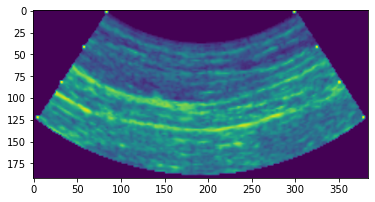

In [11]:
plt.imshow(X_test_resized[390])

### Normalizing values of image arrays

In [4]:
# normalize the values to between 0-1 to make it easier for the neural network
# X_train_normalized = np.stack(X_train_augmented).astype(np.uint8) / 255
X_train_normalized = np.stack(X_train_resized).astype(np.uint8) / 255
X_test_normalized = np.stack(X_test_resized).astype(np.uint8) / 255
X_val_normalized = np.stack(X_val_resized).astype(np.uint8) / 255

# one hot encode the pixel values of the segmented images into 4 categories
# Y_train_categorical = to_categorical(Y_train_augmented, num_classes=4)
Y_train_categorical = to_categorical(Y_train_resized, num_classes=4)
Y_test_categorical = to_categorical(Y_test_resized, num_classes=4)
Y_val_categorical = to_categorical(Y_val_resized, num_classes = 4)


# divide the training and test set into batches
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train_normalized, Y_train_categorical)).batch(16)
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test_normalized, Y_test_categorical)).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_normalized, Y_val_categorical)).batch(32)

2024-07-01 15:07:52.203789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-01 15:07:53.417146: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38295 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:32:00.0, compute capability: 8.0


## Model loading and training

### Custom Dice score

In [5]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    
    return (2. * intersection + smooth) / (union + smooth)


def weighted_dice_coefficient(y_true, y_pred, class_weights, num_classes=4):
    dice = 0
    for index in range(num_classes):
        class_dice = dice_coefficient(y_true[..., index], y_pred[..., index])
        dice += class_dice * class_weights[index]
        
    # Normalize by sum of weights for averaging
    return dice / tf.reduce_sum(class_weights)


def weighted_dice_loss(y_true, y_pred, class_weights):
    return 1 - weighted_dice_coefficient(y_true, y_pred, class_weights)

# weights for pixel classes (Other tissue, muscle, fat, outside of POV)
class_weights = tf.constant([0.5, 4, 0.5, 0.001]) 
# class_weights = tf.constant([1.0,1.0,1.0,1.0]) 

# custom loss function including the class weights
def custom_dice_loss(y_true, y_pred):
    return weighted_dice_loss(y_true, y_pred, class_weights)


In [6]:
import keras.backend as K

def dice_loss(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        y_true = K.cast(y_true, K.floatx())
        alpha_t = y_true * alpha + (K.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (K.ones_like(y_true) - y_true) * (1 - y_pred)
        fl = - alpha_t * K.pow((K.ones_like(y_true) - p_t), gamma) * K.log(p_t)
        return K.mean(fl)
    return focal_loss_fixed

def combined_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + focal_loss()(y_true, y_pred)

In [9]:
from keras import backend as K

def tversky_loss(alpha=0.5, beta=0.5):
    def loss(y_true, y_pred):
        y_true_pos = K.flatten(y_true)
        y_pred_pos = K.flatten(y_pred)
        true_pos = K.sum(y_true_pos * y_pred_pos)
        false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
        false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
        return 1 - (true_pos + K.epsilon()) / (true_pos + alpha * false_neg + beta * false_pos + K.epsilon())
    return loss

In [8]:
model = models.att_unet_2d((192,384,1), filter_num = [64,128,256,512,1024], n_labels = 4, stack_num_down=3, stack_num_up=4, activation='ReLU', 
                atten_activation='Softmax', attention='add', output_activation='Softmax', batch_norm=True, pool=True, unpool=True, 
                backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='attunet')
# model.compile(optimizer='adam', loss= custom_dice_loss, metrics=['accuracy'])
# model.compile(optimizer='adam', loss=combined_loss, metrics=['accuracy'])
model.compile(optimizer='adam', loss=custom_dice_loss, metrics=['accuracy'])


# model = models.swin_unet_2d((256,256,1), filter_num_begin = 64,depth = 4, n_labels = 4, stack_num_down=2, stack_num_up=2, 
#                       patch_size=(2,2), num_heads = [4, 8, 16, 16], window_size = [4, 2, 2, 2], num_mlp = 512, output_activation='Softmax', shift_window=True, name='swin_unet')
# model.compile(optimizer='adam', loss= custom_dice_loss, metrics=['accuracy'])


# model = models.transunet_2d((128,128,1), filter_num = [64,128,256,512], n_labels = 4, stack_num_down=2, stack_num_up=2,
#                  embed_dim=768, num_mlp = 3072, num_heads=12, num_transformer=12,
#                  activation='ReLU', mlp_activation='GELU', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, 
#                  backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='transunet')

# model = models.unet_2d((192,384,1), filter_num = [64,128,256,512,1024], n_labels = 4, stack_num_down=4, stack_num_up=3,
#             activation='ReLU', output_activation='Softmax', batch_norm=True, pool=True, unpool=True, 
#             backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='unet')
# model.compile(optimizer='adam', loss=custom_dice_loss, metrics=['accuracy'])

# model = models.unet_3plus_2d((192,384,1), n_labels = 4, filter_num_down = [32,64,128,256,512], filter_num_skip='auto', filter_num_aggregate='auto', 
#                   stack_num_down=2, stack_num_up=2, activation='ReLU', output_activation='Sigmoid',
#                   batch_norm=True, pool=True, unpool=True, deep_supervision=False, 
#                   backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='unet3plus')
# model.compile(optimizer='adam', loss=custom_dice_loss, metrics=['accuracy'])

checkpoint_filepath = 'Model_history'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',  
    mode='min',
    save_best_only=True)

In [6]:
run = 80

subfolder = 'RUNFOLDER'
model_dir = 'Model_run'

In [10]:
# Fit model without data augmentation
history = model.fit(X_train_normalized,Y_train_categorical, epochs=25, callbacks=[model_checkpoint_callback], validation_data=val_dataset, batch_size = 16)

# Fit data with data augmentation
# history = model.fit_generator(generator=train_generator, validation_data=val_dataset,steps_per_epoch=len(X_train_normalized) // 32, epochs=50, callbacks=[model_checkpoint_callback])

Epoch 1/25


2024-06-30 17:35:23.529167: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2024-06-30 17:35:27.869400: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x14a2554dbbc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-30 17:35:27.869453: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-06-30 17:35:27.903934: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-30 17:35:28.184240: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


82/82 [==============================] - ETA: 0s - loss: 0.2023 - accuracy: 0.7417

INFO:tensorflow:Assets written to: Model_history/assets


INFO:tensorflow:Assets written to: Model_history/assets


82/82 [==============================] - 86s 702ms/step - loss: 0.2023 - accuracy: 0.7417 - val_loss: 0.7483 - val_accuracy: 0.2012
Epoch 2/25
82/82 [==============================] - ETA: 0s - loss: 0.1508 - accuracy: 0.8636

INFO:tensorflow:Assets written to: Model_history/assets


INFO:tensorflow:Assets written to: Model_history/assets


82/82 [==============================] - 46s 569ms/step - loss: 0.1508 - accuracy: 0.8636 - val_loss: 0.7461 - val_accuracy: 0.2127
Epoch 3/25
82/82 [==============================] - 20s 250ms/step - loss: 0.1299 - accuracy: 0.8762 - val_loss: 0.9984 - val_accuracy: 0.3349
Epoch 4/25
82/82 [==============================] - 20s 250ms/step - loss: 0.1127 - accuracy: 0.8930 - val_loss: 0.9990 - val_accuracy: 0.3462
Epoch 5/25
82/82 [==============================] - 21s 250ms/step - loss: 0.0976 - accuracy: 0.9238 - val_loss: 0.9747 - val_accuracy: 0.3989
Epoch 6/25
82/82 [==============================] - 21s 251ms/step - loss: 0.0889 - accuracy: 0.9361 - val_loss: 0.9359 - val_accuracy: 0.3798
Epoch 7/25
82/82 [==============================] - ETA: 0s - loss: 0.0837 - accuracy: 0.9395

INFO:tensorflow:Assets written to: Model_history/assets


INFO:tensorflow:Assets written to: Model_history/assets


82/82 [==============================] - 46s 561ms/step - loss: 0.0837 - accuracy: 0.9395 - val_loss: 0.5311 - val_accuracy: 0.5092
Epoch 8/25
82/82 [==============================] - ETA: 0s - loss: 0.0810 - accuracy: 0.9419

INFO:tensorflow:Assets written to: Model_history/assets


INFO:tensorflow:Assets written to: Model_history/assets


82/82 [==============================] - 45s 557ms/step - loss: 0.0810 - accuracy: 0.9419 - val_loss: 0.4154 - val_accuracy: 0.6193
Epoch 9/25
82/82 [==============================] - ETA: 0s - loss: 0.0777 - accuracy: 0.9445

INFO:tensorflow:Assets written to: Model_history/assets


INFO:tensorflow:Assets written to: Model_history/assets


82/82 [==============================] - 46s 562ms/step - loss: 0.0777 - accuracy: 0.9445 - val_loss: 0.1711 - val_accuracy: 0.9134
Epoch 10/25
82/82 [==============================] - ETA: 0s - loss: 0.0694 - accuracy: 0.9500

INFO:tensorflow:Assets written to: Model_history/assets


INFO:tensorflow:Assets written to: Model_history/assets


82/82 [==============================] - 45s 556ms/step - loss: 0.0694 - accuracy: 0.9500 - val_loss: 0.1561 - val_accuracy: 0.9117
Epoch 11/25
82/82 [==============================] - 20s 250ms/step - loss: 0.0641 - accuracy: 0.9528 - val_loss: 0.1616 - val_accuracy: 0.8905
Epoch 12/25
82/82 [==============================] - 20s 250ms/step - loss: 0.0603 - accuracy: 0.9558 - val_loss: 0.2006 - val_accuracy: 0.8915
Epoch 13/25
82/82 [==============================] - 21s 250ms/step - loss: 0.0613 - accuracy: 0.9543 - val_loss: 0.1620 - val_accuracy: 0.9127
Epoch 14/25
82/82 [==============================] - 21s 250ms/step - loss: 0.0599 - accuracy: 0.9558 - val_loss: 0.1729 - val_accuracy: 0.9117
Epoch 15/25
82/82 [==============================] - 21s 250ms/step - loss: 0.0582 - accuracy: 0.9566 - val_loss: 0.1669 - val_accuracy: 0.9146
Epoch 16/25
82/82 [==============================] - 21s 250ms/step - loss: 0.0515 - accuracy: 0.9613 - val_loss: 0.1603 - val_accuracy: 0.9095
Epoc

In [35]:
model = tf.keras.models.load_model(checkpoint_filepath,custom_objects={'custom_dice_loss': custom_dice_loss})
# model = tf.keras.models.load_model(checkpoint_filepath,custom_objects={'combined_loss': combined_loss})
# model = tf.keras.models.load_model(checkpoint_filepath,custom_objects={'tversky_loss': tversky_loss})


model_path = os.path.join(model_dir, f'Model_{run}')
model.save(model_path, save_format='tf')

INFO:tensorflow:Assets written to: Model_run/Model_110/assets


INFO:tensorflow:Assets written to: Model_run/Model_110/assets


In [7]:
model_path = f'Model_run/Model_80'
model = tf.keras.models.load_model(model_path, custom_objects={'custom_dice_loss': custom_dice_loss})

OSError: No file or directory found at Model_run/Model_80

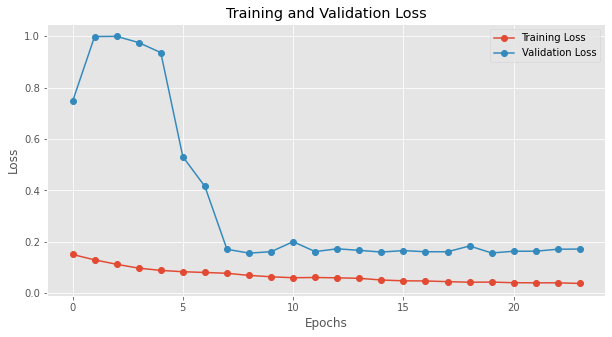

In [27]:
train_loss = history.history['loss']
train_loss = train_loss[1:]
val_loss = history.history['val_loss']
val_loss = val_loss[1:]

plt.figure(figsize=(10, 5))

plt.style.use('ggplot')
plt.grid(True)
plt.plot(train_loss, marker='o', label='Training Loss')
plt.plot(val_loss, marker='o', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
eval_result = model.evaluate(X_test_normalized, Y_test_categorical)
loss_score = eval_result[0]
accuracy_score = eval_result[1]

In [ ]:
predictions = model.predict(X_test_normalized)

In [11]:
save_dir = f'Segmentations/Model_{run}'
os.makedirs(save_dir, exist_ok=True)
for i, prediction in enumerate(predictions):
    file_path = os.path.join(save_dir, f'segmentation_{i}.npy')
    np.save(file_path, prediction)
print(f'Saved predictions for model {run} to {save_dir}')

Saved predictions for model 106 to Segmentations/Model_106


## Inspecting and evaluation results

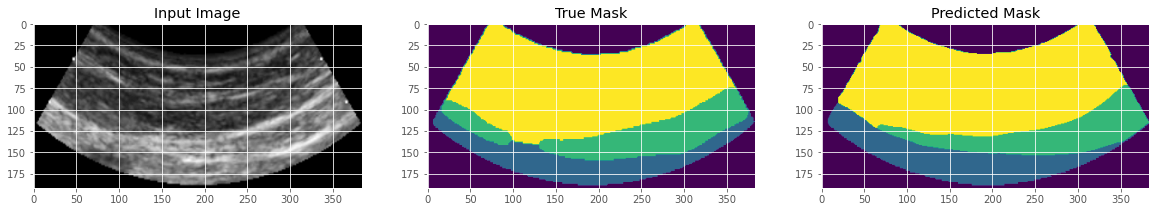

In [37]:
# load in original, true and predicted mask
n = 1
image = X_test_normalized[n]
true_mask = np.argmax(Y_test_categorical[n], axis=-1) 
predicted_mask = np.argmax(predictions[n], axis=-1) 

# visualise predictions
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].imshow(image, cmap='gray') 
axes[0].set_title('Input Image')
axes[1].imshow(true_mask, cmap='viridis')
axes[1].set_title('True Mask')
axes[2].imshow(predicted_mask, cmap='viridis')
axes[2].set_title('Predicted Mask')

filename = os.path.join(subfolder, f'run{run}_{n}.png')
plt.savefig(filename)
plt.show()

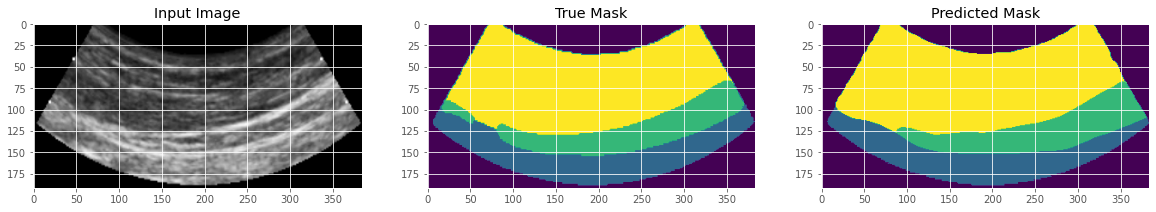

In [38]:
n = 100
image = X_test_normalized[n]
true_mask = np.argmax(Y_test_categorical[n], axis=-1) 
predicted_mask = np.argmax(predictions[n], axis=-1) 

# visualise predictions
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].imshow(image, cmap='gray') 
axes[0].set_title('Input Image')
axes[1].imshow(true_mask, cmap='viridis')
axes[1].set_title('True Mask')
axes[2].imshow(predicted_mask, cmap='viridis')
axes[2].set_title('Predicted Mask')

filename = os.path.join(subfolder, f'run{run}_{n}.png')
plt.savefig(filename)
plt.show()

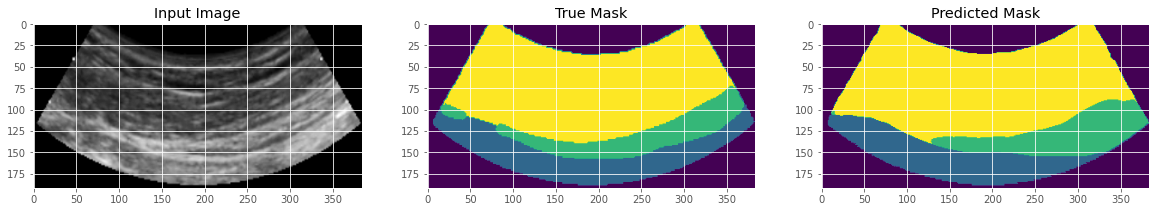

In [39]:
n = 150
image = X_test_normalized[n]
true_mask = np.argmax(Y_test_categorical[n], axis=-1) 
predicted_mask = np.argmax(predictions[n], axis=-1) 

# visualise predictions
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].imshow(image, cmap='gray') 
axes[0].set_title('Input Image')
axes[1].imshow(true_mask, cmap='viridis')
axes[1].set_title('True Mask')
axes[2].imshow(predicted_mask, cmap='viridis')
axes[2].set_title('Predicted Mask')

filename = os.path.join(subfolder, f'run{run}_{n}.png')
plt.savefig(filename)
plt.show()

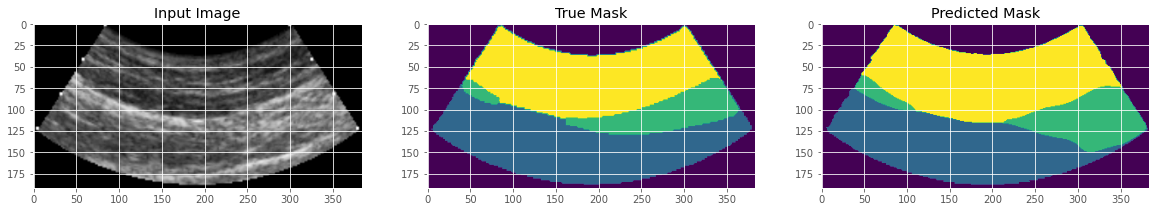

In [40]:
# load in original, true and predicted mask
m = 250
image = X_test_normalized[m]
true_mask = np.argmax(Y_test_categorical[m], axis=-1) 
predicted_mask = np.argmax(predictions[m], axis=-1) 

# visualise predictions
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].imshow(image, cmap='gray')  
axes[0].set_title('Input Image')
axes[1].imshow(true_mask, cmap='viridis')
axes[1].set_title('True Mask')
axes[2].imshow(predicted_mask, cmap='viridis')
axes[2].set_title('Predicted Mask')


filename = os.path.join(subfolder, f'run{run}_{m}.png')
plt.savefig(filename)
plt.show()

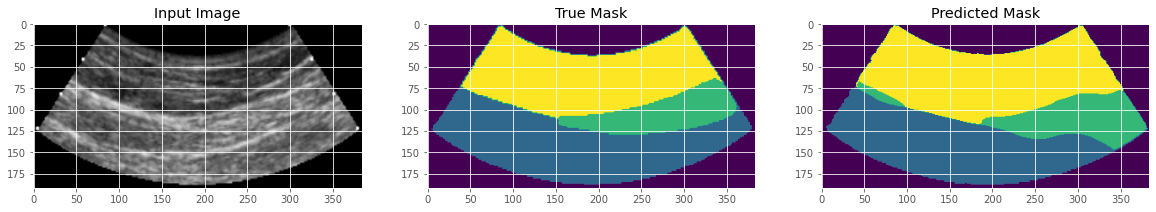

In [41]:
n = 300
image = X_test_normalized[n]
true_mask = np.argmax(Y_test_categorical[n], axis=-1) 
predicted_mask = np.argmax(predictions[n], axis=-1) 

# visualise predictions
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].imshow(image, cmap='gray') 
axes[0].set_title('Input Image')
axes[1].imshow(true_mask, cmap='viridis')
axes[1].set_title('True Mask')
axes[2].imshow(predicted_mask, cmap='viridis')
axes[2].set_title('Predicted Mask')

filename = os.path.join(subfolder, f'run{run}_{n}.png')
plt.savefig(filename)
plt.show()

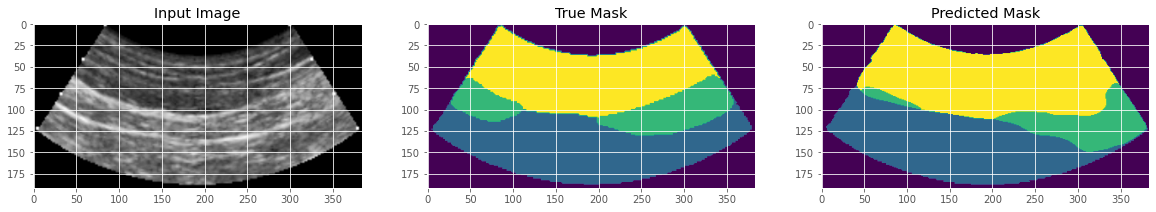

In [42]:
# load in original, true and predicted mask
m = 400
image = X_test_normalized[m]
true_mask = np.argmax(Y_test_categorical[m], axis=-1) 
predicted_mask = np.argmax(predictions[m], axis=-1) 

# visualise predictions
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].imshow(image, cmap='gray')  
axes[0].set_title('Input Image')
axes[1].imshow(true_mask, cmap='viridis')
axes[1].set_title('True Mask')
axes[2].imshow(predicted_mask, cmap='viridis')
axes[2].set_title('Predicted Mask')

filename = os.path.join(subfolder, f'run{run}_{m}.png')
plt.savefig(filename)
plt.show()




# Evaluation

In [8]:
import numpy as np
from sklearn.metrics import f1_score

def calculate_iou_single_class(y_true, y_pred):
    intersection = np.logical_and(y_true == y_pred, y_true == 1)
    union = np.logical_or(y_true == 1, y_pred == 1)
    if np.sum(union) == 0:  # Avoid division by zero
        return 1.0 if np.sum(intersection) == 0 else 0.0
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_dice_single_class(y_true, y_pred):
    intersection = np.logical_and(y_true == y_pred, y_true == 1)
    denominator = (np.sum(y_true == 1) + np.sum(y_pred == 1))
    if denominator == 0:  # Avoid division by zero
        return 1.0 if np.sum(intersection) == 0 else 0.0
    dice_score = 2 * np.sum(intersection) / denominator
    return dice_score

def calculate_iou_multiclass(y_true, y_pred, num_classes):
    iou_scores = []
    for i in range(num_classes):
        iou_score = calculate_iou_single_class(y_true == i, y_pred == i)
        iou_scores.append(iou_score)
    return np.mean(iou_scores)

def calculate_dice_multiclass(y_true, y_pred, num_classes):
    dice_scores = []
    for i in range(num_classes):
        dice_score = calculate_dice_single_class(y_true == i, y_pred == i)
        dice_scores.append(dice_score)
    return np.mean(dice_scores)

def calculate_sensitivity_single_class(y_true, y_pred):
    tp = np.sum(np.logical_and(y_pred == 1, y_true == 1))
    fn = np.sum(np.logical_and(y_pred == 0, y_true == 1))
    denominator = (tp + fn)
    if denominator == 0:
        return 0.0
    sensitivity = tp / denominator
    return sensitivity

def calculate_specificity_single_class(y_true, y_pred):
    tn = np.sum(np.logical_and(y_pred == 0, y_true == 0))
    fp = np.sum(np.logical_and(y_pred == 1, y_true == 0))
    denominator = (tn + fp)
    if denominator == 0:
        return 0.0
    specificity = tn / denominator
    return specificity

def calculate_f1_single_class(y_true, y_pred):
    return f1_score(y_true.flatten(), y_pred.flatten(), zero_division=0)

def calculate_multiclass_metrics(y_true, y_pred, num_classes):
    sensitivities = []
    specificities = []
    f1_scores = []
    
    for i in range(num_classes):
        y_true_class = (y_true == i).astype(int)
        y_pred_class = (y_pred == i).astype(int)
        
        sensitivity = calculate_sensitivity_single_class(y_true_class, y_pred_class)
        specificity = calculate_specificity_single_class(y_true_class, y_pred_class)
        f1 = calculate_f1_single_class(y_true_class, y_pred_class)
        
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        f1_scores.append(f1)
    
    return np.mean(sensitivities), np.mean(specificities), np.mean(f1_scores)

# Initialize lists for scores
iou_scores = []
dice_scores = []
muscle_iou_scores = []
muscle_dice_scores = []
sensitivity_scores = []
specificity_scores = []
f1_scores = []
muscle_sensitivity_scores = []
muscle_specificity_scores = []
muscle_f1_scores = []

# Add lists for other labels
tissue_iou_scores = []
tissue_dice_scores = []
fat_iou_scores = []
fat_dice_scores = []
outside_iou_scores = []
outside_dice_scores = []

tissue_sensitivity_scores = []
tissue_specificity_scores = []
tissue_f1_scores = []
fat_sensitivity_scores = []
fat_specificity_scores = []
fat_f1_scores = []
outside_sensitivity_scores = []
outside_specificity_scores = []
outside_f1_scores = []

for i in range(len(X_test_resized)):
    true_mask = np.argmax(Y_test_categorical[i], axis=-1)
    predicted_mask = np.argmax(predictions[i], axis=-1)
    
    # Calculate IoU and Dice for muscle class (assuming muscle class is 2)
    muscle_iou_score = calculate_iou_single_class(true_mask == 2, predicted_mask == 2)
    muscle_dice_score = calculate_dice_single_class(true_mask == 2, predicted_mask == 2)
    muscle_sensitivity = calculate_sensitivity_single_class(true_mask == 2, predicted_mask == 2)
    muscle_specificity = calculate_specificity_single_class(true_mask == 2, predicted_mask == 2)
    muscle_f1 = calculate_f1_single_class(true_mask == 2, predicted_mask == 2)
    
    # Calculate IoU and Dice for other classes (1, 3, 4)
    tissue_iou_score = calculate_iou_single_class(true_mask == 1, predicted_mask == 1)
    tissue_dice_score = calculate_dice_single_class(true_mask == 1, predicted_mask == 1)
    tissue_sensitivity = calculate_sensitivity_single_class(true_mask == 1, predicted_mask == 1)
    tissue_specificity = calculate_specificity_single_class(true_mask == 1, predicted_mask == 1)
    tissue_f1 = calculate_f1_single_class(true_mask == 1, predicted_mask == 1)
    
    fat_iou_score = calculate_iou_single_class(true_mask == 3, predicted_mask == 3)
    fat_dice_score = calculate_dice_single_class(true_mask == 3, predicted_mask == 3)
    fat_sensitivity = calculate_sensitivity_single_class(true_mask == 3, predicted_mask == 3)
    fat_specificity = calculate_specificity_single_class(true_mask == 3, predicted_mask == 3)
    fat_f1 = calculate_f1_single_class(true_mask == 3, predicted_mask == 3)
    
    outside_iou_score = calculate_iou_single_class(true_mask == 4, predicted_mask == 4)
    outside_dice_score = calculate_dice_single_class(true_mask == 4, predicted_mask == 4)
    outside_sensitivity = calculate_sensitivity_single_class(true_mask == 4, predicted_mask == 4)
    outside_specificity = calculate_specificity_single_class(true_mask == 4, predicted_mask == 4)
    outside_f1 = calculate_f1_single_class(true_mask == 4, predicted_mask == 4)
    
    # Calculate multiclass metrics
    iou_score = calculate_iou_multiclass(true_mask, predicted_mask, num_classes=4)
    dice_score = calculate_dice_multiclass(true_mask, predicted_mask, num_classes=4)
    sensitivity, specificity, f1 = calculate_multiclass_metrics(true_mask, predicted_mask, num_classes=4)
    
    muscle_iou_scores.append(muscle_iou_score)
    muscle_dice_scores.append(muscle_dice_score)
    iou_scores.append(iou_score)
    dice_scores.append(dice_score)
    muscle_sensitivity_scores.append(muscle_sensitivity)
    muscle_specificity_scores.append(muscle_specificity)
    muscle_f1_scores.append(muscle_f1)
    sensitivity_scores.append(sensitivity)
    specificity_scores.append(specificity)
    f1_scores.append(f1)
    
    tissue_iou_scores.append(tissue_iou_score)
    tissue_dice_scores.append(tissue_dice_score)
    tissue_sensitivity_scores.append(tissue_sensitivity)
    tissue_specificity_scores.append(tissue_specificity)
    tissue_f1_scores.append(tissue_f1)
    
    fat_iou_scores.append(fat_iou_score)
    fat_dice_scores.append(fat_dice_score)
    fat_sensitivity_scores.append(fat_sensitivity)
    fat_specificity_scores.append(fat_specificity)
    fat_f1_scores.append(fat_f1)
    
    outside_iou_scores.append(outside_iou_score)
    outside_dice_scores.append(outside_dice_score)
    outside_sensitivity_scores.append(outside_sensitivity)
    outside_specificity_scores.append(outside_specificity)
    outside_f1_scores.append(outside_f1)

print("Average Dice score:", np.mean(dice_scores))
print("Average IoU score:", np.mean(iou_scores))
print("Muscle Dice score:", np.mean(muscle_dice_scores))
print("Muscle IoU score:", np.mean(muscle_iou_scores))
print("Muscle Sensitivity score:", np.mean(muscle_sensitivity_scores))
print("Muscle Specificity score:", np.mean(muscle_specificity_scores))
print("Muscle F1 score:", np.mean(muscle_f1_scores))
print("Average Sensitivity score:", np.mean(sensitivity_scores))
print("Average Specificity score:", np.mean(specificity_scores))
print("Average F1 score:", np.mean(f1_scores))

print("Tissue Dice score:", np.mean(tissue_dice_scores))
print("Tissue IoU score:", np.mean(tissue_iou_scores))
print("Tissue Sensitivity score:", np.mean(tissue_sensitivity_scores))
print("Tissue Specificity score:", np.mean(tissue_specificity_scores))
print("Tissue F1 score:", np.mean(tissue_f1_scores))

print("Fat Dice score:", np.mean(fat_dice_scores))
print("Fat IoU score:", np.mean(fat_iou_scores))
print("Fat Sensitivity score:", np.mean(fat_sensitivity_scores))
print("Fat Specificity score:", np.mean(fat_specificity_scores))
print("Fat F1 score:", np.mean(fat_f1_scores))

print("Outside Dice score:", np.mean(outside_dice_scores))
print("Outside IoU score:", np.mean(outside_iou_scores))
print("Outside Sensitivity score:", np.mean(outside_sensitivity_scores))
print("Outside Specificity score:", np.mean(outside_specificity_scores))
print("Outside F1 score:", np.mean(outside_f1_scores))


NameError: name 'predictions' is not defined

## Write score to excel

In [43]:
import openpyxl

def write_scores_to_excel(run, filepath='model perf.xlsx'):
    # Load the workbook and select the active worksheet
    workbook = openpyxl.load_workbook(filepath)
    sheet = workbook.active
    
    # Define the column mapping from S to AB
    columns = ['S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'AA', 'AB','AE', 'AF']
    
    # Scores to be writtenb 
    scores = [
        np.mean(dice_scores),
        np.mean(iou_scores),
        np.mean(muscle_dice_scores),
        np.mean(muscle_iou_scores),
        np.mean(muscle_sensitivity_scores),
        np.mean(muscle_specificity_scores),
        np.mean(muscle_f1_scores),
        np.mean(sensitivity_scores),
        np.mean(specificity_scores),
        np.mean(f1_scores),
        loss_score,
        accuracy_score
        
    ]
    
    # Write the scores to the corresponding columns and row
    for col, score in zip(columns, scores):
        sheet[f'{col}{run}'] = score
    
    # Save the workbook
    workbook.save(filepath)
    print(f'Scores successfully written to {filepath} in row {run}.')
    
    
write_scores_to_excel(run = run)

Scores successfully written to model perf.xlsx in row 109.


## Plot and save the ROC curve

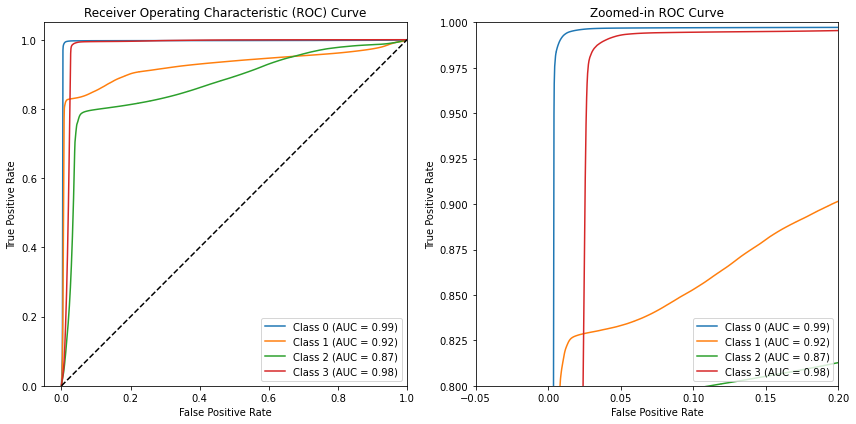

In [44]:
import numpy as np
import pickle
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import os

def plot_roc_curve(y_true, y_pred, num_classes, filename='roc_curve.png', pickle_filename='roc_curve.pkl'):
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Flatten the arrays
    y_true_flat = y_true.reshape(-1, num_classes)
    y_pred_flat = y_pred.reshape(-1, num_classes)
    
    # Calculate ROC curve and AUC for each class
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_flat[:, i], y_pred_flat[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 6))

    # Full ROC curve
    plt.subplot(1, 2, 1)
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([-0.05, 1.0])  # Adjust xlim to add whitespace before 0
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

    # Zoomed-in ROC curve
    plt.subplot(1, 2, 2)
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([-0.05, 0.2])
    plt.ylim([0.8, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Zoomed-in ROC Curve')
    plt.legend(loc='lower right')

    plt.tight_layout()
    
    # Save the plot as a PNG file
    plt.savefig(filename)
    
    # Save the figure as a pickle file
    with open(pickle_filename, 'wb') as f:
        pickle.dump(plt.gcf(), f)
    
    plt.show()

# Example usage with test data
num_classes = 4  # Adjust to match the number of classes
y_true_one_hot = np.array(Y_test_categorical)  # One-hot encoded ground truth
y_pred_one_hot = np.array(predictions)  # One-hot encoded predictions

plot_roc_curve(y_true_one_hot, y_pred_one_hot, num_classes, filename=os.path.join(subfolder, f'run{run}_ROC.png'), pickle_filename=os.path.join(subfolder, f'run{run}_ROC.pkl'))
